First, We need to import the required packages.

In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from CNN.nn.conv import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

Using TensorFlow backend.


Then, we will initialize the data and labels

In [2]:
data = []
labels = []

The SMILES dataset consists of imgaes of faces that with either $smiling$ or $not \ smiling^{[1]}$. There are 13,165 images in the dataset, and each image have a size of 64*64 pixels. 9,475 of these examples are $not \ smiling$ and 3,690 belong to the $smiling$ class.

We loop over the input images.
For each of these images:
    1. Load it
    2. Convert it to grayscale
    3. Resize it to have a fixed input scale(28x28)
    4. Convert the image to an array compatible with Keras
    5. Add the image to the data
    
Then, we extract the labels from the imagePath and updating it in the labels list.

In [3]:
for imagePath in sorted(list(paths.list_images("datasets/SMILEsmileD"))):
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width=28)
    image = img_to_array(image)
    data.append(image)

    
    label = imagePath.split(os.path.sep)[-3]
    label = "smiling" if label == "positives" else "not_smiling"
    labels.append(label)

Then, we scale the raw pixel intensities to the range[0,1] and then apply one-hot encoding to the labels.

In [4]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

We convert the labels from integers to vectors

In [5]:
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)

We compute the total number of examples per class. In our code, classTotals will be an array: [9475, 3690] for $"not \ smiling"$ and $"smiling"$. 

Then we scale these totals to obtain the classWeight used to handle the class imbalance issue, which yields the array: [1, 2.56]. This weighting implies that our network will treat every instance of “smiling” as 2.56 instances of “not smiling” and helps solve the class imbalance issue by amplifying the per-instance loss by a larger weight when seeing “smiling” examples.

In [6]:
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

We partitioned our data into training and testing parts.
We used 80% of the data for training and 20% for testing.

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.20, stratify=labels, random_state=42)

Finally, we trained the LetNet.

In [8]:
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
    class_weight=classWeight, batch_size=64, epochs=15, verbose=1)

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=le.classes_))

print("[INFO] serializing network...")
model.save("output/lenet.hdf5")

[INFO] compiling model...
[INFO] training network...
Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 20s - loss: 0.4171 - acc: 0.8062 - val_loss: 0.2868 - val_acc: 0.8804
Epoch 2/15
10532/10532 [==============================] - 19s - loss: 0.2709 - acc: 0.8904 - val_loss: 0.2689 - val_acc: 0.8872
Epoch 3/15
10532/10532 [==============================] - 20s - loss: 0.2464 - acc: 0.9017 - val_loss: 0.2550 - val_acc: 0.8994
Epoch 4/15
10532/10532 [==============================] - 19s - loss: 0.2300 - acc: 0.9089 - val_loss: 0.2646 - val_acc: 0.8899
Epoch 5/15
10532/10532 [==============================] - 19s - loss: 0.2168 - acc: 0.9165 - val_loss: 0.2318 - val_acc: 0.9088
Epoch 6/15
10532/10532 [==============================] - 21s - loss: 0.2023 - acc: 0.9209 - val_loss: 0.2446 - val_acc: 0.9047
Epoch 7/15
10532/10532 [==============================] - 20s - loss: 0.1905 - acc: 0.9267 - val_loss: 0.2391 - val_acc: 0.9062
Ep

Visualized the performance:

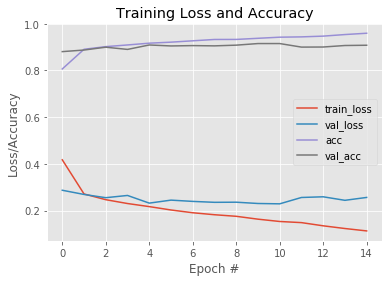

In [9]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend();

References: 

[1]Daniel Hromada. SMILEsmileD. https://github.com/hromi/SMILEsmileD.2010.